In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from math import radians, atan, tan, sin, acos, cos
from sklearn.model_selection import train_test_split

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score

import progressbar
import warnings
warnings.filterwarnings('ignore')

# 1.0 Introduction
美国东北大学一个科研团队的一项研究表明，人类93%的行为都是可以预测的，想一想我们的规律生活，就会觉得这个数字并不是那么夸张。也正因如此， 交通才得以合理规划，城市才得以有序发展。 在实际应用中，其实并没有那么容易预测，数据的缺乏是一个重要的原因。那么在有限的数据下，我们能够在多大程度上预测出人们的行为呢？

## 1.1 Evaluation :

score of the distance
<img src="img/eval1.png",width=200,height=60>
<img src="img/eval2.png",width=270,height=60>
where di is the distance (in metre), n is the number of samples. (the best sccore is 0.01798, when all the distance is 0)

# 2 Data (EDA)

In [47]:
train_df = pd.read_csv('train.csv', low_memory=False)
test_df = pd.read_csv('test.csv', low_memory=False)

In [3]:
print('the shape of the training set is :', train_df.shape)
train_df.head()

the shape of the training set is : (1495814, 8)


,r_key,out_id,start_time,end_time,start_lat,start_lon,end_lat,end_lon
0,SDK-XJ_609994b4d50a8a07a64d41d1f70bbb05,2016061820000b,2018-01-20 10:13:43,2018-01-20 10:19:04,33.783415,111.603660,33.779811,111.605885
1,SDK-XJ_4c2f29d94c9478623711756e4ae34cc5,2016061820000b,2018-02-12 17:40:51,2018-02-12 17:58:13,34.810763,115.549264,34.814875,115.549374
2,SDK-XJ_3570183177536a575b9da67a86efcd62,2016061820000b,2018-02-13 14:52:24,2018-02-13 15:24:33,34.640284,115.539024,34.813136,115.559243
3,SDK-XJ_78d749a376e190685716a51a6704010b,2016061820000b,2018-02-13 17:23:08,2018-02-13 17:39:02,34.818280,115.542039,34.813141,115.559217
4,SDK-XJ_3b249941c27834f5e43d43a9114e4909,2016061820000b,2018-02-13 18:06:02,2018-02-13 19:02:51,34.813278,115.559260,34.786126,115.874361


r_key is the sample id. out_id is the car id. No nan value

## 1.1 get the distance of all training set

In [14]:
def getDistance(latA, lonA, latB, lonB):  
    ra = 6378140  			# radius of equator: meter  
    rb = 6356755  			# radius of polar: meter  
    flatten = (ra - rb) / ra  	# Partial rate of the earth  
    # change angle to radians  
    radLatA = np.pi*(latA)/180
    radLonA = np.pi*(lonA)/180  
    radLatB = np.pi*(latB)/180  
    radLonB = np.pi*(lonB)/180  
    try: 
        pA = np.arctan(rb / ra * np.tan(radLatA))  
        pB = np.arctan(rb / ra * np.tan(radLatB))  
        x = np.arccos(np.sin(pA) * np.sin(pB) + np.cos(pA) * np.cos(pB) * np.cos(radLonA - radLonB))  
        c1 = (np.sin(x) - x) * (np.sin(pA) + np.sin(pB))**2 / np.cos(x / 2)**2  
        c2 = (np.sin(x) + x) * (np.sin(pA) - np.sin(pB))**2 / np.sin(x / 2)**2  
        dr = flatten / 8 * (c1 - c2)  
        distance = ra * (x + dr)  
        return distance			# meter  
    except:
        return 0.0000001

In [15]:
distance = getDistance(train_df['start_lat'], train_df['start_lon'] , train_df['end_lat'], train_df['end_lon'])
train_df['distance'] = distance

## 1.2 get the time duration of trainning set

In [3]:
train_df['duration'] = (pd.to_datetime(train_df.end_time) - pd.to_datetime(train_df.start_time)).dt.total_seconds()

In [4]:
print('the min and max of start lat is :', train_df.start_lat.min(), train_df.start_lat.max())
print('the min and max of start lon is :', train_df.start_lon.min(), train_df.start_lon.max())

the min and max of start lat is : 18.222925 49.746388
the min and max of start lon is : 75.03050400000002 134.75346399999998


## 1.3 start position
let's see the start position of the data

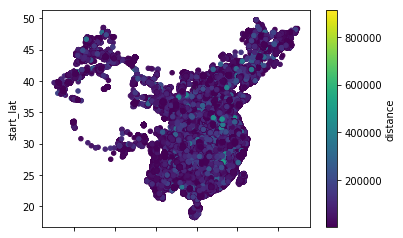

In [42]:
ax2 = train_df.plot.scatter(x='start_lon',
                       y='start_lat',
                       c='distance',
                       colormap='viridis')

I found the corresponding map from google , which is about:
![title](img/map.PNG)
the data are took from all over the country

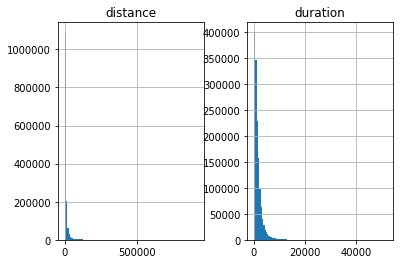

In [50]:
hist = train_df[['distance', 'duration']].hist(bins=100)

## 1.4 time and the distance
let's see the relation between the time and the distance.

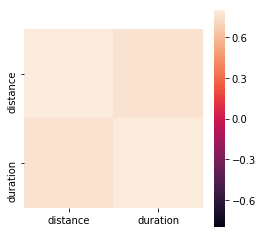

In [52]:
df_train = train_df.drop(columns=['r_key', 'out_id','start_time','end_time', 'start_lat',  'start_lon',  'end_lat',  'end_lon'])
df_train_norm = (df_train - df_train.mean()) / (df_train.max() - df_train.min())
# df_train['target'] = df_train.returnsOpenNextMktres11 >= 0
# correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(corrmat, vmax=.8, vmin=-.8, square=True)

## 1.5 ids

In [5]:
print('the maximum of the number of samples of a single car is :',
     train_df.groupby('out_id').count().max().r_key)
print('the minimum of the number of samples of a single car is :',
     train_df.groupby('out_id').count().min().r_key)
print('the mean of the number of samples of a single car is :',
     train_df.groupby('out_id').count().mean().r_key)

the maximum of the number of samples of a single car is : 582
the minimum of the number of samples of a single car is : 87
the mean of the number of samples of a single car is : 257.14526388172595


In [23]:
# train_df.out_id.value_counts().shape

In [16]:
temp_df =  train_df[ train_df.out_id == 'CT910M01E2AA08GG00270']

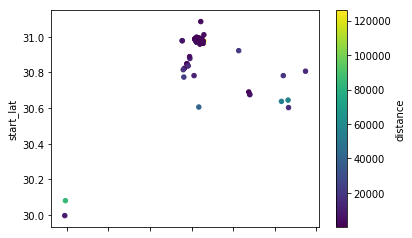

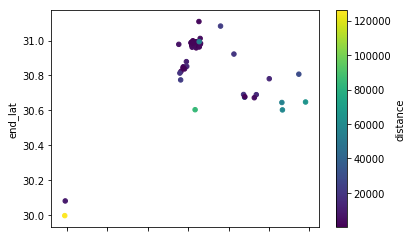

In [20]:
ax2 = temp_df.plot.scatter(x='start_lon',
                       y='start_lat',
                       c='distance',
                       colormap='viridis')
ax2 = temp_df.plot.scatter(x='end_lon',
                       y='end_lat',
                       c='distance',
                       colormap='viridis')

In [21]:
temp_df = train_df[train_df.out_id == 'CT910M01E2AA08GG00270']
temp_df = temp_df[temp_df.start_lat < 30.4]

In [22]:
temp_df

,r_key,out_id,start_time,end_time,start_lat,start_lon,end_lat,end_lon,duration,distance
1495755,SDK-XJ_43cd5313699a53bb321a7d3da7ee2e7f,CT910M01E2AA08GG00270,2018-04-30 07:57:09,2018-04-30 08:34:30,29.996248,102.990157,30.079962,102.992810,2241.0,9283.476218
1495756,SDK-XJ_20abbfeb13eb8f6dbdd0d1e0125fc8ca,CT910M01E2AA08GG00270,2018-04-30 14:11:21,2018-04-30 16:17:38,30.079982,102.992993,30.603222,103.634664,7577.0,84683.891554


# Data augmentation
- Take the reverse of start and end as new data set.
- As the duration is mostly small, it won't effect a lot the result. So leave it alone for now. (todo later)

In [35]:
train_df_new = train_df.copy()
train_df_new.rename(columns={'start_lat':'end_lat','start_lon':'end_lon', 
                             'end_lat':'start_lat','end_lon':'start_lon'}, inplace=True)
train_df = pd.concat([train_df, train_df_new])
print('the shape of the new training set is :', train_df.shape)

the shape of the new training set is : (2991628, 10)


# Make submission
## 1  submission of the same position 

In [3]:
example_test_df = pd.read_csv('sample.csv', low_memory=False)

In [9]:
print(example_test_df.shape, test_df.shape)
example_test_df.head()

(47493, 3) (47493, 5)


,r_key,end_lat,end_lon
0,SDK-XJ_7534ad707d53c355b3f99e60873e0078,34,117
1,SDK-XJ_cb264818af319586fe1b5590220d6538,34,117
2,SDK-XJ_5866d63b8453b2dd0c7353c0ad22989d,34,117
3,SDK-XJ_f58ce77e4b2733867b19f83506acfe2c,34,117
4,SDK-XJ_aef2eed237cd4a22b1fc7ffcc2b214aa,34,117


In [15]:
submission_df = test_df.drop(columns=['out_id','start_time'])
submission_df.rename(columns={'start_lat':'end_lat','start_lon':'end_lon'}, inplace=True)
submission_df.head()

,r_key,end_lat,end_lon
0,SDK-XJ_212b1190d5924bc6225557f1105b2b21,34.873591,117.573400
1,SDK-XJ_1acf33d4e624fc5b0ff259c23743de0f,34.846818,117.565654
2,SDK-XJ_5866d63b8453b2dd0c7353c0ad22989d,34.873579,117.573436
3,SDK-XJ_e670157d7b0eaeb7ee11ae7b953e9a2e,34.873735,117.573475
4,SDK-XJ_aef2eed237cd4a22b1fc7ffcc2b214aa,34.846793,117.565553


In [97]:
submission_df.to_csv('submission.csv', index=False)

score is 0.81609

## 2 bayes

In [16]:
train_df['start_time_hour'] = (pd.to_datetime(train_df.start_time)).dt.hour

In [32]:
# parameters
interval = np.arcsin(100/6371000)*180/np.pi
inv_hour = 1

In [34]:
def choose_sub_df(time, lat, lon):
    temp_df = train_df[(train_df.start_time_hour <= int(time[11:13])+inv_hour ) 
                       & (train_df.start_time_hour >= int(time[11:13])-inv_hour )]
    temp_df = temp_df[(temp_df.start_lat <= lat+interval ) & (temp_df.start_lat >= lat-interval )]
    temp_df = temp_df[(temp_df.start_lon <= lon+interval ) & (temp_df.start_lon >= lon-interval )]
    return temp_df

In [35]:
def reject_outlier(sub_df):
    vari_lat = max(sub_df.max().end_lat-sub_df.mean().end_lat, sub_df.mean().end_lat-sub_df.min().end_lat)
    vari_lon = max(sub_df.max().end_lon-sub_df.mean().end_lon, sub_df.mean().end_lon-sub_df.min().end_lon)
    sub_df = sub_df[(sub_df.end_lat <= sub_df.mean().end_lat+vari_lat*0.8 )
                    & (sub_df.end_lat >= sub_df.mean().end_lat-vari_lat*0.8 )]
    sub_df = sub_df[(sub_df.end_lon <= sub_df.mean().end_lon+vari_lon*0.8 )
                    & (sub_df.end_lon >= sub_df.mean().end_lon-vari_lon*0.8 )]
    return sub_df.mean().end_lat, sub_df.mean().end_lon, sub_df.shape[0]

In [36]:
widgets = [progressbar.Percentage(), progressbar.Bar()]
bar = progressbar.ProgressBar(widgets=widgets, maxval=test_df.shape[0]).start()

non_count = 0
for i in range(test_df.shape[0]):
    current = test_df.iloc[i]
    time = current['start_time']
    lat = current['start_lat']
    lon = current['start_lon']
    sub_df = choose_sub_df(time, lat, lon)
    end_lat, end_lon , iff= reject_outlier(sub_df)
    if iff == 0:
        end_lat = lat
        end_lon = lon
        non_count += 1
    submission_df.set_value(i, 'end_lat', end_lat)
    submission_df.set_value(i, 'end_lon', end_lon)
    bar.update(i + 1)
bar.finish()
submission_df.head()
print('percentage of non values is :', non_count/test_df.shape[0])

percentage of non values is : 0.2251910807908534


In [37]:
submission_df.to_csv('submission_3.csv', index=False)

### 2018/10/25
- interval of radius : about 100 metres
- interval time : 1 houor
- score 0.55

### 2018/10/26
- with data augmentation (size 2 times bigger)
- interval of radius : about 100 metres
- interval time : 2 houor
- percentage of non values is : 0.18512201798159728
- score 0.59

### 2018/10/26
- with data augmentation (size 2 times bigger)
- interval of radius : about 100 metres
- interval time : 1 houor
- percentage of non values is : 0.2251910807908534
- score because of changement of the test data, no result

plan: ensembling 
- group behaviour (model upper)
- client behaviour (common visited place of the client)

## 3 based on personal info

In [34]:
ids = train_df.out_id.unique()
not_in_trainset = []
n_count = 0
for i in range(test_df.shape[0]):
    current = test_df.iloc[i]
    car_id = current['out_id']
    if car_id not in ids:
        n_count += 1
        not_in_trainset.append(car_id)
print('there is(are) ', n_count, ' id(s) not in training set.')

there is(are)  0  id(s) not in training set.


In [48]:
train_df['start_time_hour'] = (pd.to_datetime(train_df.start_time)).dt.hour

In [49]:
def choose_sub_df_v2(temp_df, time, lat, lon, interval, inv_hour):
    temp_df = temp_df[(temp_df.start_time_hour <= int(time[11:13])+inv_hour ) 
                       & (temp_df.start_time_hour >= int(time[11:13])-inv_hour )]
    temp_df = temp_df[(temp_df.start_lat <= lat+interval ) & (temp_df.start_lat >= lat-interval )]
    temp_df = temp_df[(temp_df.start_lon <= lon+interval ) & (temp_df.start_lon >= lon-interval )]
    return temp_df

In [64]:
def choose_sub_df_id(time, lat, lon, car_id):
    max_iter = 20
    temp_df = train_df
    id_sorted_df = temp_df[temp_df.out_id == car_id]
    
    gotten = False
    for i in range(max_iter):
        range_in_meter = 100 + 20*i
        interval = np.arcsin(range_in_meter/6371000)*180/np.pi
        inv_hour = 1 + 0.5*i
        temp_df_phy = choose_sub_df_v2(id_sorted_df, time, lat, lon, interval, inv_hour)
        # if we got some samples, make another enlargement, and set it as the final sub set.
        # to have more data in the set
        if gotten:
            break
        if temp_df_phy.shape[0] >= 1:
            gotten = True
            
    if temp_df_phy.shape[0] == 0:
        id_sorted_df['dist'] = abs(id_sorted_df['start_lat'] - lat) + abs(id_sorted_df['start_lon'] - lon)
        temp_df_phy = id_sorted_df.sort_values(by=['dist']).head(5)
    
    return temp_df_phy

In [61]:
def calculate_predict(sub_df):
    vari_lat = max(sub_df.max().end_lat-sub_df.mean().end_lat, sub_df.mean().end_lat-sub_df.min().end_lat)
    vari_lon = max(sub_df.max().end_lon-sub_df.mean().end_lon, sub_df.mean().end_lon-sub_df.min().end_lon)
    if sub_df.shape[0] > 10:
        sub_df = sub_df[(sub_df.end_lat <= sub_df.mean().end_lat+vari_lat*0.8 )
                    & (sub_df.end_lat >= sub_df.mean().end_lat-vari_lat*0.8 )]
        sub_df = sub_df[(sub_df.end_lon <= sub_df.mean().end_lon+vari_lon*0.8 )
                    & (sub_df.end_lon >= sub_df.mean().end_lon-vari_lon*0.8 )]
    return sub_df.mean().end_lat, sub_df.mean().end_lon, sub_df.shape[0]

In [62]:
submission_df = test_df.drop(columns=['out_id','start_time'])
submission_df.rename(columns={'start_lat':'end_lat','start_lon':'end_lon'}, inplace=True)

In [65]:
widgets = [progressbar.Percentage(), progressbar.Bar()]
bar = progressbar.ProgressBar(widgets=widgets, maxval=test_df.shape[0]).start()

non_count = 0
err_set = []
for i in range(test_df.shape[0]):
    current = test_df.iloc[i]
    time = current['start_time']
    lat = current['start_lat']
    lon = current['start_lon']
    car_id = current['out_id']
    sub_df = choose_sub_df_id(time, lat, lon, car_id)
    end_lat, end_lon , iff = calculate_predict(sub_df)
    if iff == 0:
        end_lat = lat
        end_lon = lon
        non_count += 1
        err_set.append(current)
    submission_df.set_value(i, 'end_lat', end_lat)
    submission_df.set_value(i, 'end_lon', end_lon)
    bar.update(i + 1)
bar.finish()
submission_df.head()
print('percentage of non values is :', non_count/test_df.shape[0])

percentage of non values is : 0.0006196533383823605


- no data augementation , max_iter 20, (7381 non values), score: 0.55x
- data augementation , max_iter 10, (7513 non values), score: 0.58x
- no DA, max_iter 20, further (36 non values), score: 0.550

In [70]:
submission_df.to_csv('submission_id2.csv', index=False)